# Modeling

## Overview

From the initial EDA, we learned of a few interesting relationships:
<br>
<br>1. Negative linear relationship between temperature and gas usage
<br>2. (Somewhat) Linear relationship between gas usage, temperature, and PM10 particulate occurance
<br>3. Cyclic behaviour in generation of gas, electricity, and PM10 particulate occurance
<br><br>
We will explore these relationships in hopes of creating accurate models to predict behaviours in related data points.

## Temperature and Gas Usage: Linear Regression

The first relationship we will explore is between temperature and gas usage. In the initial EDA, we saw quite a linear relationship, so we will focus on *linear regression* to predict gas usage based on the temperatures across the different provinces.

### Import extensions and data

In [1]:
# Extensions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import date
%matplotlib inline

In [24]:
# Modeling 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn import metrics
#from sklearn.metrics import precision_score, recall_score

In [45]:
# Electricity and Gas
df = pd.read_excel('Data/Korea_Electricity_and_Gas.xlsx')

# Gas
locs = list(range(0,3)) + list(range(19,35))
gas = df.iloc[:,locs]
gas

,Year,Month,Temperature,Gangwondo_Gas,Gyeonggido_Gas,Gyeongsangnamdo_Gas,Gyeongsangbukdo_Gas,Jeollanamdo_Gas,Jeollabukdo_Gas,Jeju_Gas,Chungcheongnamdo_Gas,Chungcheongbukdo_Gas,Seoul_Gas,Incheon_Gas,Gwangju_Gas,Daegu_Gas,Daejeon_Gas,Busan_Gas,Ulsan_Gas
0,2000,1,-1.20,16219,363014,42129,55362,22508,34507,0,20158,27838,662424,139454,39465,86077,52992,85787,69241
1,2000,2,-0.99,16280,375937,42604,52863,22310,33784,0,23492,27175,689177,145834,40674,84069,53950,87282,70910
2,2000,3,6.64,14105,323145,35990,47282,18033,29315,0,21156,22904,566528,121324,34610,76144,41898,74476,63627
3,2000,4,12.11,10364,237437,28698,40393,15920,19783,0,17447,16818,396231,91421,25898,62514,28618,58316,47106
4,2000,5,17.59,6843,169495,21073,35083,13808,14375,0,14508,12299,262940,67239,18426,46992,17503,45915,43749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,8,27.00,19076,255222,60523,84646,49039,43885,1506,70181,49460,163032,70646,27561,45058,31906,70508,94251
248,2020,9,21.40,18822,243817,65264,88652,54253,48190,1179,86971,53589,147556,72542,28120,43042,30307,70849,101433
249,2020,10,14.90,25946,339823,75071,103757,60416,61328,1414,109095,61315,213556,78654,39428,44555,42001,85283,119332
250,2020,11,9.00,35632,497221,101609,135432,68793,82360,2161,142556,82499,375289,115663,58120,67054,69624,122943,147792


In [46]:
gas['DATE'] = pd.to_datetime(gas[['Year', 'Month']].assign(DAY=1))
gas.DATE

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
247   2020-08-01
248   2020-09-01
249   2020-10-01
250   2020-11-01
251   2020-12-01
Name: DATE, Length: 252, dtype: datetime64[ns]

In [47]:
# Weather (Temperature)
weather = pd.read_excel('Data/Korea Average Temperature by Region.xlsx')
weather

,Year,Month,Overall,Gangwondo,Gyeonggido,Gyeongsamnamdo,Gyeongsambukdo,Jeollanamdo,Jeollabukdo,Jeju,Chungcheongnamdo,Chungcheongbukdo,Seoul,Incheon,Gwangju,Daegu,Daejeon,Busan,Ulsan
0,2000,1,-1.20,-3.0,-2.1,3.3,2.7,1.0,0.8,6,-,-1.2,-2.1,-1.5,1.0,1.1,-1.2,4.2,3.1
1,2000,2,-0.99,-3.2,-1.7,3.0,2.3,0.6,0.2,4.6,-,-1.6,-1.7,-1.2,0.6,1.3,-1.1,3.2,2.7
2,2000,3,6.64,4.9,6.3,8.9,8.9,6.9,6.9,9.4,-,5.7,6.3,6.0,6.9,7.9,6.1,9.1,8.7
3,2000,4,12.11,10.8,11.9,13.4,13.9,12.6,12.8,13.5,-,11.5,11.9,11.5,12.6,13.0,11.9,13.2,13.6
4,2000,5,17.59,16.7,17.5,17.9,18.7,17.8,18.2,17.2,-,17.2,17.5,16.5,17.8,19.5,17.2,17.3,18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,8,27.00,26.1,26.5,27.5,28.6,27.6,27.7,29.4,26.8,27.7,26.5,25.9,27.6,28.6,27.5,27.2,27.6
248,2020,9,21.40,19.7,21.4,21.5,21.6,21.3,21.3,22.9,20.7,21.5,21.4,21.3,21.3,21.2,21.2,21.9,21.1
249,2020,10,14.90,11.9,14.3,16.0,16.4,15.7,14.9,18.4,13.2,14.5,14.3,14.8,15.7,15.4,14.2,17.3,15.9
250,2020,11,9.00,6.1,8.0,10.7,11.3,10.5,9.6,14.1,8.1,8.8,8.0,8.3,10.5,9.7,8.6,12.4,11.0


Note that there are missing values in the 'Chungcheongnamdo' column of the temperature data. However, the two dataframes are the same size 252 rows x 19 columns (with an additional DATE row added to the gas dataframe).

### Dealing with missing values

In the gas dataset, the 'Jeju' column has many 0 values, which aren't necessarily expected, but could just be a replacement for unknown values. We will leave it for now.

In [48]:
gas.isnull().sum()

Year                    0
Month                   0
Temperature             0
Gangwondo_Gas           0
Gyeonggido_Gas          0
Gyeongsangnamdo_Gas     0
Gyeongsangbukdo_Gas     0
Jeollanamdo_Gas         0
Jeollabukdo_Gas         0
Jeju_Gas                0
Chungcheongnamdo_Gas    0
Chungcheongbukdo_Gas    0
Seoul_Gas               0
Incheon_Gas             0
Gwangju_Gas             0
Daegu_Gas               0
Daejeon_Gas             0
Busan_Gas               0
Ulsan_Gas               0
DATE                    0
dtype: int64

On the other hand, the weather dataframe has several '-' values, used to represent unknown data as well! Let's see the scale of unknown values.

In [49]:
(weather == '-').sum()

Year                  0
Month                 0
Overall               0
Gangwondo             0
Gyeonggido            0
Gyeongsamnamdo        0
Gyeongsambukdo        0
Jeollanamdo           0
Jeollabukdo           0
Jeju                  2
Chungcheongnamdo    204
Chungcheongbukdo      0
Seoul                 0
Incheon               0
Gwangju               0
Daegu                 0
Daejeon               0
Busan                 0
Ulsan                 0
dtype: int64

Here, we can see that there are 204 unknown values in the 'Chungcheongnamdo' column (out of 252 rows). There is <b>too much missing data here</b>, so for now we will just <b>remove the province</b> from our considerations. There are also 2 unknown values for 'Jeju', but since they are so few, we can just use an *average temperature to replace these values*.

In [50]:
# Remove the Chungcheongnamdo column from both dataframes
weather = weather.drop(columns='Chungcheongnamdo')
gas = gas.drop(columns='Chungcheongnamdo_Gas')

In [51]:
weather[weather.Jeju == '-']

,Year,Month,Overall,Gangwondo,Gyeonggido,Gyeongsamnamdo,Gyeongsambukdo,Jeollanamdo,Jeollabukdo,Jeju,Chungcheongbukdo,Seoul,Incheon,Gwangju,Daegu,Daejeon,Busan,Ulsan
204,2017,1,-0.35,-3.0,-1.8,2.6,2.9,2.0,0.8,-,-0.8,-1.8,-0.9,2.0,1.1,-0.4,4.1,2.8
213,2017,10,16.57,13.9,16.4,17.5,17.5,17.0,16.0,-,15.9,16.4,15.7,17.0,16.2,15.4,18.1,17.0


We can see here that the two missing values in 'Jeju' are from January and October of 2017. We'll replace these values with the average temperature in Jeju for these months.

In [52]:
# Create replacement value for January and October
january = weather[weather.Month == 1]
jeju_january = january['Jeju'].drop(index=204)
jeju_january_replace = jeju_january.mean()

october = weather[weather.Month == 10]
jeju_october = october['Jeju'].drop(index=213)
jeju_october_replace = jeju_october.mean().round(2)

print(jeju_january_replace, jeju_october_replace)

6.03 18.72


In [53]:
# Replace:
weather.loc[204,'Jeju']=jeju_january_replace
weather.loc[213,'Jeju']=jeju_october_replace
(weather == '-').sum()

Year                0
Month               0
Overall             0
Gangwondo           0
Gyeonggido          0
Gyeongsamnamdo      0
Gyeongsambukdo      0
Jeollanamdo         0
Jeollabukdo         0
Jeju                0
Chungcheongbukdo    0
Seoul               0
Incheon             0
Gwangju             0
Daegu               0
Daejeon             0
Busan               0
Ulsan               0
dtype: int64

### Normalize Data
Let's define a function to normalize the varying data (temperature, gas output, pollutant presence, etc). We will be using this for each region eventually, so it will be useful to have.

In [54]:
def normalize(df):
    for column in df.columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min()) 
    return df

And we use this function to normalize values in our dataframes. This will let us see the impact and error in a more understandable way. We can also later compare the error of using this feature in Linear Regression to later error.

In [71]:
weather_norm = normalize(weather)
gas_norm = normalize(gas)

### Split data to test and training sets
Split data into training and testing data, with an 80/20 split. Since we have multiple provinces and cities, we can separately train models for each. However, let's first try to train a model using only the 'Gyeonggido' province data.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(weather_norm.Gyeonggido, gas_norm.Gyeonggido_Gas, test_size=0.2)

In [73]:
print(X_train.shape, y_train.shape)
X_train.head()

(201,) (201,)


249    0.597222
143    0.175000
129    0.602778
150    0.905556
161    0.877778
Name: Gyeonggido, dtype: float64

### Deploying and evaluating Ordinary Least Squares Linear Regression Model

In [74]:
linReg = LinearRegression()
linReg.fit(X_train.array.reshape(-1,1), y_train)

LinearRegression()

In [75]:
y_pred = linReg.predict(X_test.array.reshape(-1,1))
print(linReg.intercept_, linReg.coef_)

0.7854941497945334 [-0.77632414]


In [76]:
rss = np.sum((y_test - y_pred)**2)
ess = np.sum((y_pred - np.mean(y_test))**2)
r2 = (ess/(ess + rss)).round(3)
print('R-Squared value for the model: ', r2)

R-Squared value for the model:  0.81


In [77]:
fstat = ((r2/(1-r2))*250).round(1)
print('F-stat value for the model: ', fstat)

F-stat value for the model:  1065.8


In [78]:
print("RMS Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMS Error:  0.09997240334967475


In [79]:
import statsmodels.formula.api as smf

In [80]:
smlin = smf.ols(formula='Temperature ~ Gyeonggido_Gas', data=gas).fit()
smlin.params
print(smlin.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     847.9
Date:                Thu, 15 Jun 2023   Prob (F-statistic):           2.71e-82
Time:                        01:46:37   Log-Likelihood:                 151.81
No. Observations:                 252   AIC:                            -299.6
Df Residuals:                     250   BIC:                            -292.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9129      0.015     61.

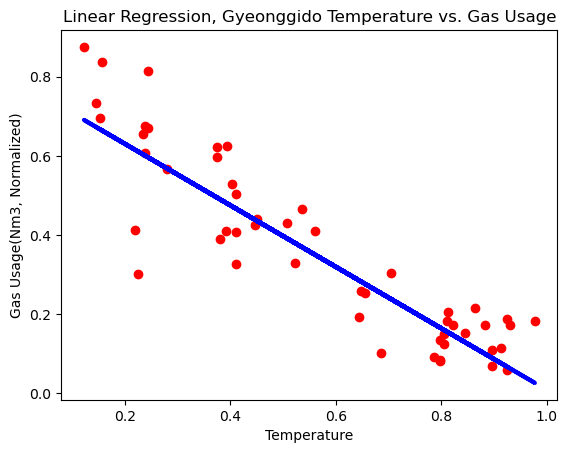

In [82]:
plt.scatter(X_test, y_test, color='r')
plt.plot(X_test, y_pred, color='b', linewidth=3)
plt.xlabel('Temperature')
plt.ylabel('Gas Usage(Nm3, Normalized)')
plt.title('Linear Regression, Gyeonggido Temperature vs. Gas Usage');

Here, we see how the model fits to our data, and is able to predict with a <b>RMSE of about 0.1</b>. This isn't great, but as we can see on the graph as well, it generally does fit the data. Let's try to see if we can do better with a different Linear Regression Model!

### Gradient Descent Linear Regression Model

In [83]:
from sklearn import linear_model
linReg2 = linear_model.SGDRegressor(max_iter=1000, tol=1e-5, random_state=0)
linReg2.fit(X_train.array.reshape(-1,1), y_train)

SGDRegressor(random_state=0, tol=1e-05)

In [84]:
y_pred2 = linReg2.predict(X_test.array.reshape(-1,1))
print(linReg2.intercept_, linReg2.coef_)

[0.71705379] [-0.66055287]


In [85]:
rss = np.sum((y_test - y_pred2)**2)
ess = np.sum((y_pred2 - np.mean(y_test))**2)
r2 = (ess/(ess + rss)).round(3)
print('R-Squared value for the model: ', r2)

R-Squared value for the model:  0.736


In [86]:
fstat = ((r2/(1-r2))*250).round(1)
print('F-stat value for the model: ', fstat)

F-stat value for the model:  697.0


In [87]:
print("RMS Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

RMS Error:  0.10562190924343692


We also tried using Gradient Descent to fit a linear regression to the data, but the RMSE is similar (perhaps even a little worse in this case), with a value of <b>RMSE=~0.106</b>.
<br>
The models are shown below:

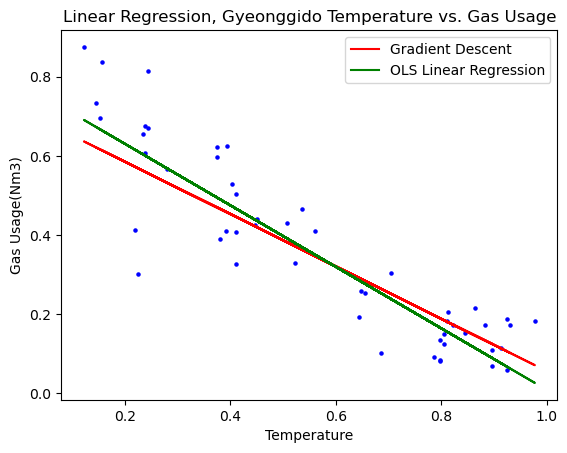

In [88]:
plt.scatter(X_test, y_test, color='b', s=5)
plt.plot(X_test, y_pred2, color='red', label='Gradient Descent')
plt.plot(X_test, y_pred, color='green', label='OLS Linear Regression')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Gas Usage(Nm3)')
plt.title('Linear Regression, Gyeonggido Temperature vs. Gas Usage');

## Initial Takeaway
From using these two types of linear regression (albeit without much tuning), we can see a decently useful relationship between temperature and gas usage. <b>The models both have an error of about 0.1</b>, but we can do better! Let's try with some other models.


## Cleaned Dataset and training with other models
As shown in the EDA, some other features may not be as suitable for a linear regression model. Let's try a different model, adding in some other potentially impactful features!
<br><br>
<u>The additional features we will include are:</u>
<br>1. Carbon Monoxide
<br>2. Nitrogen Dioxide
<br>3. Ozone
<br>4. Sulfuric Acid Gas
<br>5. PM10
<br><br>We will use these new features, along with the already present temperature, to predict gas generation in Normalized cubic meters (Nm3).

We can read in the information from the cleaned 'Korea_Data_All' excel file, which contains all of the additional features we've discussed. It is also cleaned up (missing values, year differences, missing regional values) in the way that we've discussed prior, in both this notebook and the initial EDA.

In [4]:
gyeonggi_full = pd.read_excel('Data/Korea_Data_All.xlsx',sheet_name=2)
gyeonggi_full

,Year,Month,Gyeonggido_Elec,Gyeonggido_Gas,Gyeonggi_PM10,Gyeonggi_Ozone,Gyeonggi_SO3,Gyeonggi_NO2,Gyeonggi_CO,Gyeonggido_Temp
0,2010,1,744.101205,738025,68,0.011,0.008,0.040,0.9,-4.5
1,2010,2,713.740016,610984,56,0.015,0.007,0.034,0.7,1.4
2,2010,3,731.995382,500288,67,0.023,0.005,0.028,0.6,4.3
3,2010,4,817.928450,439879,57,0.026,0.005,0.030,0.5,9.5
4,2010,5,700.898429,298335,66,0.033,0.005,0.029,0.5,17.2
...,...,...,...,...,...,...,...,...,...,...
127,2020,8,6047.920142,255222,24,0.023,0.003,0.011,0.3,26.5
128,2020,9,6285.545956,243817,22,0.029,0.003,0.013,0.4,21.4
129,2020,10,5805.792953,339823,38,0.022,0.003,0.022,0.5,14.3
130,2020,11,5313.923434,497221,45,0.017,0.003,0.027,0.5,8.0


In [5]:
print(gyeonggi_full.isna().sum())
(gyeonggi_full == '-').sum()

Year               0
Month              0
Gyeonggido_Elec    0
Gyeonggido_Gas     0
Gyeonggi_PM10      0
Gyeonggi_Ozone     0
Gyeonggi_SO3       0
Gyeonggi_NO2       0
Gyeonggi_CO        0
Gyeonggido_Temp    0
dtype: int64


Year               0
Month              0
Gyeonggido_Elec    0
Gyeonggido_Gas     0
Gyeonggi_PM10      0
Gyeonggi_Ozone     0
Gyeonggi_SO3       0
Gyeonggi_NO2       0
Gyeonggi_CO        0
Gyeonggido_Temp    0
dtype: int64

### Normalize full dataset data

In [7]:
gyeonggi_norm = gyeonggi_full.copy()
gyeonggi_norm = normalize(gyeonggi_norm.drop(columns=['Year', 'Month']))
gyeonggi_norm

,Gyeonggido_Elec,Gyeonggido_Gas,Gyeonggi_PM10,Gyeonggi_Ozone,Gyeonggi_SO3,Gyeonggi_NO2,Gyeonggi_CO,Gyeonggido_Temp
0,0.002289,0.818530,0.696970,0.026316,1.0,0.90625,1.000000,0.075000
1,0.001870,0.629182,0.515152,0.131579,0.8,0.71875,0.666667,0.238889
2,0.002122,0.464195,0.681818,0.342105,0.4,0.53125,0.500000,0.319444
3,0.003309,0.374158,0.530303,0.421053,0.4,0.59375,0.333333,0.463889
4,0.001693,0.163194,0.666667,0.605263,0.4,0.56250,0.333333,0.677778
...,...,...,...,...,...,...,...,...
127,0.075536,0.098936,0.030303,0.342105,0.0,0.00000,0.000000,0.936111
128,0.078818,0.081938,0.000000,0.500000,0.0,0.06250,0.166667,0.794444
129,0.072193,0.225030,0.242424,0.315789,0.0,0.34375,0.333333,0.597222
130,0.065400,0.459624,0.348485,0.184211,0.0,0.50000,0.333333,0.422222


Let's separate our target and features. We will try predicting the generated gas (Nm3) from the pollutants and temperature, so the gas will be the target.

In [8]:
# Separate target and features
target = gyeonggi_norm.Gyeonggido_Gas
features = gyeonggi_norm.drop(columns='Gyeonggido_Gas')

In [9]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=17)

## Random Forest Regression
Let's try another kind of regressor for this data, which we saw was somewhat linearly dependent in the EDA. 

In [37]:
# initialize regressor
forest = RandomForestRegressor(random_state=42)
forest = forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

### Calculating Error
For regression problems, we can focus on error values like Mean Squared Error and Root Mean Squared Error to see how well our model is performing in comparison to the actual target values.

In [38]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Basic Random Forest): ', mse)
print('RMSE (Basic Random Forest): ', rmse)

MSE (Basic Random Forest):  0.0028854058740435885
RMSE (Basic Random Forest):  0.05371597410494935


The error is not too bad, as our values are between 0 and 1 (normalized), and the error is <1e-1 even in the RMSE case.

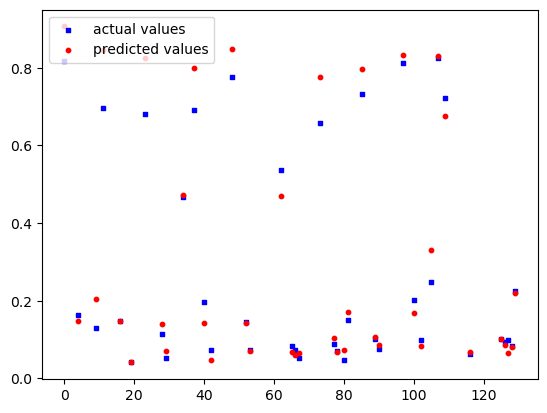

In [12]:
# just visualizing the data for now
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test.index, y_test, s=10, c='b', marker="s", label='actual values')
ax1.scatter(X_test.index,y_pred, s=10, c='r', marker="o", label='predicted values')
plt.legend(loc='upper left')
plt.show()

### Tuning the regressor
Grid search to find general good parameter areas

In [18]:
# define models and parameters
model = RandomForestRegressor()
grid = {
    'n_estimators': [10,100,400,800],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3,4,5,6,7],
    'random_state': [42]
}

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [33]:
# define grid search
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

# start grid search
result = search.fit(features, target)

In [34]:
print(result.best_score_)
print(result.best_params_)

-0.005651236965687644
{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}


Let's see how it performs on the data we previously used:

In [39]:
# initialize again, with tuned hyperparameters
forest_tuned = RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=100, random_state=42)
fores_tunedt = forest_tuned.fit(X_train, y_train)
y_pred = forest_tuned.predict(X_test)

Once again calculating the error:

In [41]:
mse_tuned = mean_squared_error(y_test, y_pred)
rmse_tuned = mse_tuned**.5
print('MSE (Tuned Random Forest): ', mse_tuned)
print('RMSE (Tuned Random Forest): ', rmse_tuned)
print('MSE (Basic Random Forest): ', mse)
print('RMSE (Basic Random Forest): ', rmse)

MSE (Tuned Random Forest):  0.0023584042500577004
RMSE (Tuned Random Forest):  0.04856340443232641
MSE (Basic Random Forest):  0.0028854058740435885
RMSE (Basic Random Forest):  0.05371597410494935


### Results
Just from this quick grid search tuning, we can see a slight decrease in error for both MSE and RMSE. Our final error values for the random forest are: 
<br>
<b>MSE: 0.00236
<br>
RMSE: 0.0537</b>
<br><br>
If we compare to the RMSE values of using linear regression models, we can already see a significant improvement (0.1 -> 0.05)!